In [4]:
import pickle 
from data_loader import build_vocab, get_loader
from model import EncoderCNN, DecoderRNN 
from model import ResNet, ResidualBlock
from torch.autograd import Variable 
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import torch
import torch.nn as nn

root_path = './data/bitmap2svg_samples/'
batch_size= 128
num_workers = 2
vocab_path = 'data/vocab.pkl'
#vocab = build_vocab(root_path, threshold=0)
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
    
transform = transforms.Compose([ 
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])
    
# Build data loader
data_loader = get_loader(root_path, vocab, 
                         transform, batch_size,
                         
                         shuffle=True, num_workers=num_workers) 
#encoder = EncoderCNN(256)
encoder = ResNet(ResidualBlock, [3, 3, 3], 256)
decoder = DecoderRNN(256, 512, 
                     len(vocab),1)

if torch.cuda.is_available():
    encoder.cuda(1)
    decoder.cuda(1)

In [6]:
import numpy as np
num_epochs = 5 
batch_size = 128
learning_rate = 0.001
log_step = 10
plot_every = 5 

all_losses =  [] 
all_accuarcy = [] 
all_exact_accuracy = []

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
#params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)


def rearrange_tensor(x, batch_size, caption_size):
    for i in range(caption_size):
        temp = x[i*batch_size:(i+1)*batch_size].view(batch_size, -1)
        if i == 0:
            temp_cat = temp 
        else: 
            temp_cat = torch.cat((temp_cat,  temp), 1)

    return temp_cat


def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda(1)
    return Variable(x, volatile=volatile)


total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):

        # Set mini-batch dataset
        images = to_var(images)
        captions = to_var(captions)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]            
        # Forward, Backward and Optimize
        decoder.zero_grad()
        encoder.zero_grad()
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f'
                  %(epoch, num_epochs, i, total_step, 
                    loss.data[0], np.exp(loss.data[0]))) 

            ##test set accuracy 
            #rearrange tensor to batch_size * caption_size 
            re_target = rearrange_tensor(targets, batch_size, captions.size(1))
            re_out_max = rearrange_tensor(outputs.max(1)[1], batch_size, captions.size(1))
            #convert to numpy 
            outputs_np = re_out_max.cpu().data.numpy()
            targets_np = re_target.cpu().data.numpy()

            location_match = 0 
            exact_match = 0             
            for i in range(len(targets_np)):
 
                if(outputs_np[i][1] == targets_np[i][1]):
                    location_match +=1
                if(np.array_equal(outputs_np[i], targets_np[i])):
                    exact_match +=1 
            print('location match accuracy: %.4f, exact match accuracy: %4.f'
             %(location_match/len(targets_np), exact_match/len(targets_np)))
            
            all_losses.append(loss.data[0])
            all_accuarcy.append(location_match/len(targets_np))
            all_exact_accuracy.append(exact_match/len(targets_np))

                

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f990d14c668>>
Traceback (most recent call last):
  File "/home/penielrome/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 241, in __del__
    self._shutdown_workers()
  File "/home/penielrome/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 237, in _shutdown_workers
    self.index_queue.put(None)
  File "/home/penielrome/anaconda3/lib/python3.6/multiprocessing/queues.py", line 355, in put
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f990d14c668>>
    self._writer.send_bytes(obj)
Traceback (most recent call last):
  File "/home/penielrome/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
  File "/home/penielrome/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 241, in __del__
    self._s

Epoch [0/5], Step [0/107], Loss: 3.2425, Perplexity: 25.5976
location match accuracy: 0.0000, exact match accuracy:    0
Epoch [0/5], Step [10/107], Loss: 1.4541, Perplexity: 4.2807
location match accuracy: 0.1172, exact match accuracy:    0
Epoch [0/5], Step [20/107], Loss: 0.9793, Perplexity: 2.6627
location match accuracy: 0.0547, exact match accuracy:    0
Epoch [0/5], Step [30/107], Loss: 0.9363, Perplexity: 2.5504
location match accuracy: 0.1406, exact match accuracy:    0
Epoch [0/5], Step [40/107], Loss: 0.9412, Perplexity: 2.5630
location match accuracy: 0.0781, exact match accuracy:    0
Epoch [0/5], Step [50/107], Loss: 0.9292, Perplexity: 2.5325
location match accuracy: 0.1406, exact match accuracy:    0
Epoch [0/5], Step [60/107], Loss: 0.9288, Perplexity: 2.5316
location match accuracy: 0.1562, exact match accuracy:    0
Epoch [0/5], Step [70/107], Loss: 0.9360, Perplexity: 2.5497
location match accuracy: 0.0781, exact match accuracy:    0
Epoch [0/5], Step [80/107], Loss

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(1)
plt.plot(all_losses)

plt.figure(2)
plt.plot(all_accuarcy)

plt.figure(3)
plt.plot(all_exact_accuracy)



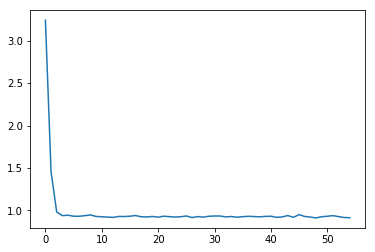

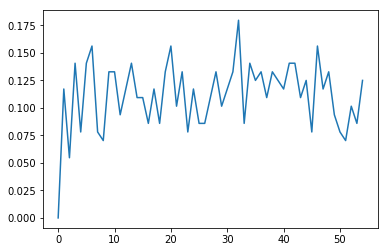

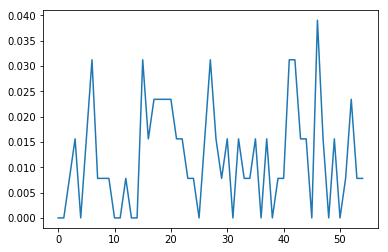

In [8]:
plt.show()